# 💣 gRNAde Design Notebook

**gRNAde**: **G**eometric Deep Learning pipeline for 3D **RNA** inverse **de**sign.
This notebook provides the following functionality:
- **Ready to use:** Full functional usage of pre-trained gRNAde models for fixed backbone re-design of RNA structures from your own PDB files.
- **Custom constraints:** Add your own design constraints, e.g. fixing key functional nucleotides, conditioning the remaining sequence on conserved nucleotides, biasing sampling.
- **Rank designs:** Evaluation and visualization tools for designed RNA sequences, including metrics for selecting amongst designs: sequence recovery, perplexity, 2D self-consistency score (EternaFold), 3D self-consistency scores (RhoFold), chemical modification self-consistency score (RibonanzaNet).

In [1]:
# Import libraries and set up the environment

import sys
sys.path.append('../')

import dotenv
dotenv.load_dotenv("../.env")

import os
import random
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F

import lovely_tensors as lt
lt.monkey_patch()

from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

from src.data.featurizer import RNAGraphFeaturizer
from src.models import AutoregressiveMultiGNNv1
from src.evaluator import (
    self_consistency_score_eternafold, 
    self_consistency_score_ribonanzanet,
    self_consistency_score_rhofold,
    edit_distance
)
from src.data.sec_struct_utils import predict_sec_struct
from src.data.viz_utlils import print_rna_data, draw_2d_struct
from src.constants import NUM_TO_LETTER, PROJECT_PATH

from gRNAde import CHECKPOINT_PATH, set_seed

from tools.ribonanzanet.network import RibonanzaNet
from tools.rhofold.rf import RhoFold
from tools.rhofold.config import rhofold_config

In [2]:
##################
# Design scenario
##################

# Single state or multi state design?
# - 1: single state
# - 2, 3, 5: multi state (number of states)
max_num_conformers = 1

# Model checkpoint split:
# - options include 'all', 'das', 'multi'
# - unless benchmarking, we recommend using 'all' for general usage
split = 'all'

# random seed for reproducibility
seed = 0

# Default model hyperparameters (do not change)
VERSION = 0.2
RADIUS = 0.0
TOP_K = 32
NUM_RBF = 32
NUM_POSENC = 32
NOISE_SCALE = 0.1
NODE_IN_DIM = (15, 4)
NODE_H_DIM = (128, 16)
EDGE_IN_DIM = (131, 3)
EDGE_H_DIM = (64, 4)
NUM_LAYERS = 4
DROP_RATE = 0.5
OUT_DIM = 4
DEFAULT_N_SAMPLES = 16
DEFAULT_TEMPERATURE = 0.1

In [3]:
#########################################
# Initialise gRNAde model and featurizer
#########################################

# Set random seed
set_seed(seed)

# Set device (GPU/CPU)
device = torch.device("cuda:{}".format(0) if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define data featurizer
print(f"Creating RNA graph featurizer for max_num_conformers={max_num_conformers}")
featurizer = RNAGraphFeaturizer(
    split = "test",  # set to 'train' to use noise augmentation
    radius = RADIUS,
    top_k = TOP_K,
    num_rbf = NUM_RBF,
    num_posenc = NUM_POSENC,
    max_num_conformers = max_num_conformers,
    noise_scale = NOISE_SCALE
)
# nucleotide mapping: {'A': 0, 'G': 1, 'C': 2, 'U': 3}

# Initialise model
print(f"Initialising GNN encoder-decoder model")
model = AutoregressiveMultiGNNv1(
    node_in_dim = NODE_IN_DIM,
    node_h_dim = NODE_H_DIM, 
    edge_in_dim = EDGE_IN_DIM,
    edge_h_dim = EDGE_H_DIM, 
    num_layers = NUM_LAYERS,
    drop_rate = DROP_RATE,
    out_dim = OUT_DIM
)
# Load model checkpoint
model_path = CHECKPOINT_PATH[split][max_num_conformers]
print(f"Loading gRNAde checkpoint: {model_path}")
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
# Transfer model to device in eval mode
model = model.to(device)
model.eval()

#########################################
# Initialise other models for evaluation
#########################################

# Initialise RibonanzaNet for 1D self-consistency score
ribonanza_net = RibonanzaNet(
    os.path.join(PROJECT_PATH, '/tools/ribonanzanet/config.yaml'),
    os.path.join(PROJECT_PATH, '/tools/ribonanzanet/ribonanzanet.pt'),
    device
)
# Transfer model to device in eval mode
ribonanza_net = ribonanza_net.to(device)
ribonanza_net.eval()

# Initialise RhoFold for 3D self-consistency score
rhofold = RhoFold(rhofold_config, device)
rhofold_path = os.path.join(PROJECT_PATH, "/tools/rhofold/model_20221010_params.pt")
print(f"Loading RhoFold checkpoint: {rhofold_path}")
rhofold.load_state_dict(torch.load(rhofold_path, map_location=torch.device('cpu'))['model'])
# Transfer model to device in eval mode
rhofold = rhofold.to(device)
rhofold.eval()
print()

Using device: cuda:0
Creating RNA graph featurizer for max_num_conformers=1
Initialising GNN encoder-decoder model
Loading gRNAde checkpoint: /home/ckj24/rna-inverse-folding/checkpoints/gRNAde_ARv1_1state_all.h5
Loading RibonanzaNet checkpoint: /home/ckj24/rna-inverse-folding/tools/ribonanzanet/ribonanzanet.pt
Loading RhoFold checkpoint: /home/ckj24/rna-inverse-folding/tools/rhofold/model_20221010_params.pt



### Load PDB file and featurize

🚨 **Notes:** 
- gRNAde currently does not support other ligands, non-standard nucleotides or non-RNA entities in its input. Your PDB file should be cleared of these. We expect a PDB file format similar to [RNAsolo](https://rnasolo.cs.put.poznan.pl/).
- Nucleotides with missing atoms (usually the P at the 5' or 3' end nucleotide) are currently ignored during design. You could either manually add back missing positions into designs within this notebook, or delete all the rows for these nucleotides in your input PDB file. I realiser this is pesky, and am working on fixing it! 


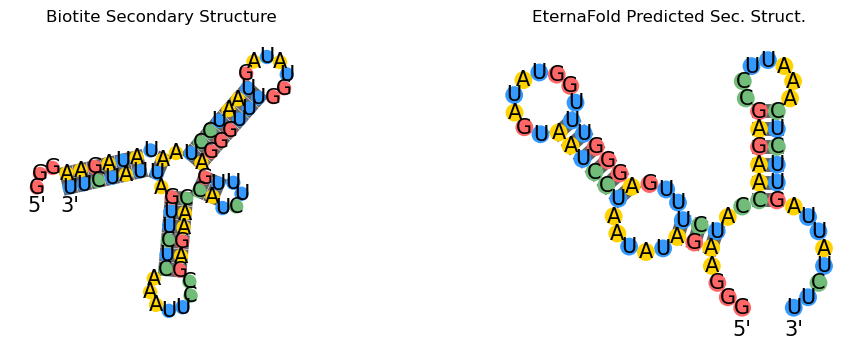

sequence:
	GGGAAGAUAUAAUCCUAAUGAUAUGGUUUGGGAGUUUCUACCAAGAGCCUUAAACUCUUGAUUAUCUU
coords_list:
	tensor[68, 3, 3] n=612 (2.4Kb) x∈[-29.815, 28.403] μ=0.052 σ=11.331
sec_struct_list:
	...((((((.(.(((((((.......)))))))((....))((((((.......)))))).)))))))
eterna_sec_struct_list:
	....(((.....((((((.........))))))...)))..((((((.......))))))........
ribonanzanet_chem_mod:
	tensor[68, 2] n=136 x∈[5.461e-05, 1.005] μ=0.271 σ=0.276
Featurized PyG Data object:
	 Data(edge_index=[2, 2558], seq=[68], node_s=[68, 1, 15], node_v=[68, 1, 4, 3], edge_s=[2558, 1, 131], edge_v=[2558, 1, 3, 3], mask_confs=[68, 1], mask_coords=[68])


In [4]:
##############################
# Load PDB file and featurize
##############################

pdb_filepath = os.path.join(PROJECT_PATH, "/tutorial/demo_data/adenine_riboswitch/5E54_1_B.pdb")

featurized_data, raw_data = featurizer.featurize_from_pdb_file(pdb_filepath)
# for multi-state design, use: featurize_from_pdb_filelist

# Add predicted secondary structure using EternaFold
raw_data['eterna_sec_struct_list'] = predict_sec_struct(raw_data['sequence'])

# Add predicted chemical modifications using RibonanzaNet
raw_data['ribonanzanet_chem_mod'] = ribonanza_net.predict(raw_data['sequence'])

plt.figure(figsize=(12, 4))
ax1 = plt.subplot(1, 2, 1)
plt.title('Biotite Secondary Structure')
draw_2d_struct(raw_data['sequence'], raw_data['sec_struct_list'][0], ax=ax1)
ax2 = plt.subplot(1, 2, 2)
plt.title('EternaFold Predicted Sec. Struct.')
draw_2d_struct(raw_data['sequence'], raw_data['eterna_sec_struct_list'][0], ax=ax2)
plt.show()

print_rna_data(raw_data)

print("Featurized PyG Data object:\n\t", featurized_data)

In [7]:
###############################
# Partial sequence constraints
###############################

print("Raw sequence:        ", raw_data['sequence'])
print("Featurized sequence: ", "".join([featurizer.num_to_letter[num] for num in featurized_data.seq.cpu().numpy()]))
# Sometimes, the first nucleotide is not included in the featurized sequence due to missing Phosphate coordinates.
# In this case, we can add the first nucleotide manually back to designed sequences with very minor post processing.

# Set partial sequence constraints (all _'s are designable positions)
partial_seq = "".join(["_"]*len(featurized_data.seq))
print(f"Partial sequence:    ", partial_seq)

# Add sequence constraints to partial_seq here:
# For instance, we may want to fix key base pairs based on the secondary structure
# sequence:    GGGAAGAUAUAAUCCUAAUGAUAUGGUUUGGGAGUUUCUACCAAGAGCCUUAAACUCUUGAUUAUCUU
# sec.struct.: ...((((((.(.(((((((.......)))))))((....))((((((.......)))))).)))))))
#
partial_seq = '__________________U_______U______GU____AC_____G_______C_____________'
print(f"Partial sequence:    ", partial_seq)
print(f"Edit distance after fixing positions: {edit_distance(raw_data['sequence'], partial_seq)}")

# transfer data to device
featurized_data = featurized_data.to(device)

# create logit bias matrix if partial sequence is provided
if partial_seq is not None:
    # convert partial sequence to tensor
    _partial_seq = []
    for residue in partial_seq:
        if residue in featurizer.letter_to_num.keys():
            # fixed nucleotide
            _partial_seq.append(featurizer.letter_to_num[residue])
        else:
            # designable position
            _partial_seq.append(len(featurizer.letter_to_num.keys()))
    _partial_seq = torch.as_tensor(_partial_seq, device=device, dtype=torch.long)
    # convert to one-hot and create bias matrix used during sampling
    logit_bias = F.one_hot(_partial_seq, num_classes=model.out_dim+1).float()
    
    #########################################################
    # Create final logit_bias matrix for masked sampling
    # - you can manually adjust the bias for more customised 
    #   designs and constraints. 
    #########################################################
    logit_bias = logit_bias[:, :-1] * 100.0
else:
    logit_bias = None

Raw sequence:         GGGAAGAUAUAAUCCUAAUGAUAUGGUUUGGGAGUUUCUACCAAGAGCCUUAAACUCUUGAUUAUCUU
Featurized sequence:  GGGAAGAUAUAAUCCUAAUGAUAUGGUUUGGGAGUUUCUACCAAGAGCCUUAAACUCUUGAUUAUCUU
Partial sequence:     ____________________________________________________________________
Partial sequence:     __________________U_______U______GU____AC_____G_______C_____________
Edit distance after fixing positions: 60


In [9]:
##############################
# Sequence design and scoring
##############################

# Create output directory
current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
output_dir = os.path.join(PROJECT_PATH, f"designs/{current_datetime}/")
os.makedirs(output_dir, exist_ok=True)
# Alternatively, you can specify a custom output directory

# Number of designed samples
n_samples = 4

# Sampling temperature
# - Low temperature (eg. 0.1) : more greedy sampling, generally higher sequence recovery
# - High temperature (eg. 1.0) : more diverse sampling, generally lower sequence recovery
temperature = 0.5

# sample n_samples from model for single data point: n_samples x seq_len
samples, logits = model.sample(
    featurized_data, n_samples, temperature, logit_bias, return_logits=True)

# perplexity per sample: n_samples x 1
n_nodes = logits.shape[1]
perplexity = torch.exp(F.cross_entropy(
    logits.view(n_samples * n_nodes, model.out_dim), 
    samples.view(n_samples * n_nodes).long(), 
    reduction="none"
).view(n_samples, n_nodes).mean(dim=1)).cpu().numpy()

# sequence recovery per sample: n_samples x 1
recovery = samples.eq(featurized_data.seq).float().mean(dim=1).cpu().numpy()

# global self consistency score (2D, EternaFold) per sample: n_samples x 1
sc_score, pred_sec_structs = self_consistency_score_eternafold(
    samples.cpu().numpy(), 
    raw_data['sec_struct_list'], 
    featurized_data.mask_coords.cpu().numpy(), # np.array([True] * len(raw_data['sequence']))
    return_sec_structs = True
)

# global self consistency score (1D, RibonanzaNet) per sample: n_samples x 1
sc_score_ribonanza, pred_chem_mods = self_consistency_score_ribonanzanet(
    samples.cpu().numpy(), 
    raw_data["sequence"], 
    featurized_data.mask_coords.cpu().numpy(),
    ribonanza_net,
    return_chem_mods = True
)

# global self consistency score (3D, RhoFold) per sample: n_samples x 1
sc_score_rmsd, sc_score_tm, sc_score_gdt = self_consistency_score_rhofold(
    samples.cpu().numpy(), 
    raw_data,
    featurized_data.mask_coords.cpu().numpy(),
    rhofold,
    output_dir,
    save_structures = True
)

>sample=0, gRNAde_ARv1_1state_all.h5 seed=0 temperature=0.5 perplexity=1.3460 recovery=0.7794 edit_dist=15 sc_score=0.9037 sc_score_ribonanzanet=0.1381 sc_score_rmsd=2.5182 sc_score_tm=0.7325 sc_score_gdt=0.7316
GGCUGGACACAAGCGUCAUGAUAUGGUUGGCGCGUUUAUACCAAGAGCCUUAAACUCUUG
AUUGUCCA

Sample 0
    Designed sequence:    GGCUGGACACAAGCGUCAUGAUAUGGUUGGCGCGUUUAUACCAAGAGCCUUAAACUCUUGAUUGUCCA
    Groundtruth sequence: GGGAAGAUAUAAUCCUAAUGAUAUGGUUUGGGAGUUUCUACCAAGAGCCUUAAACUCUUGAUUAUCUU
    Perplexity: 1.3460
    Recovery: 0.7794
    Edit distance: 15

    Predicted secondary structure:   ...((((((...((((((.........))))))........((((((.......))))))..))))))
    Groundtruth secondary structure: ...((((((.(.(((((((.......)))))))((....))((((((.......)))))).)))))))
    SC Score (MCC using EternaFold): 0.9037
    SC Score (MAE using RibonanzaNet): 0.1381
    SC Score (RMSD using RhoFold): 2.5182
    SC Score (TM using RhoFold): 0.7325
    SC Score (GDT using RhoFold): 0.7316


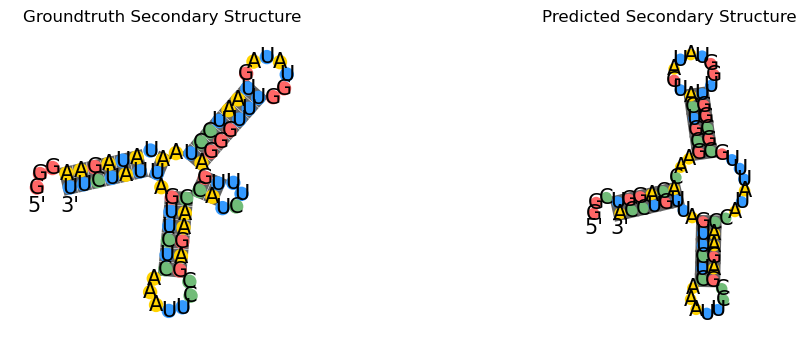

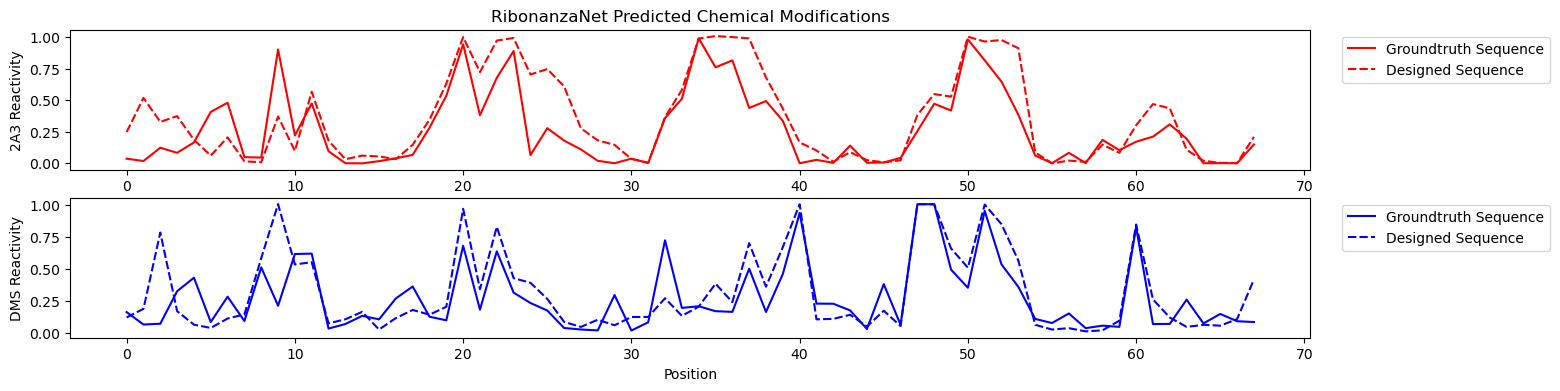

______________________________________________________________________________________________________________________________________________________
>sample=1, gRNAde_ARv1_1state_all.h5 seed=0 temperature=0.5 perplexity=1.3357 recovery=0.6765 edit_dist=22 sc_score=0.8087 sc_score_ribonanzanet=0.1563 sc_score_rmsd=3.4146 sc_score_tm=0.5332 sc_score_gdt=0.5221
GGGGGCAUGCAACCGUCAUGAUAUGGUUGGCGGGUAUAGACCAGAAGCCUUAAACUUCUG
AUCAUGCC

Sample 1
    Designed sequence:    GGGGGCAUGCAACCGUCAUGAUAUGGUUGGCGGGUAUAGACCAGAAGCCUUAAACUUCUGAUCAUGCC
    Groundtruth sequence: GGGAAGAUAUAAUCCUAAUGAUAUGGUUUGGGAGUUUCUACCAAGAGCCUUAAACUCUUGAUUAUCUU
    Perplexity: 1.3357
    Recovery: 0.6765
    Edit distance: 22

    Predicted secondary structure:   ...(((((.(..((((((.........)))))))....((.((((((.......)))))).)))))))
    Groundtruth secondary structure: ...((((((.(.(((((((.......)))))))((....))((((((.......)))))).)))))))
    SC Score (MCC using EternaFold): 0.8087
    SC Score (MAE using RibonanzaNet): 0.156

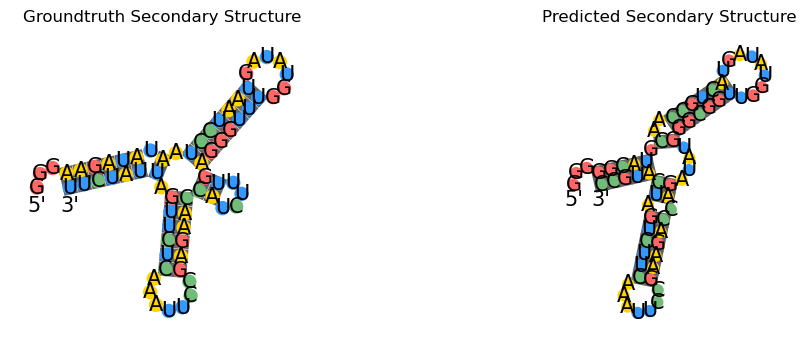

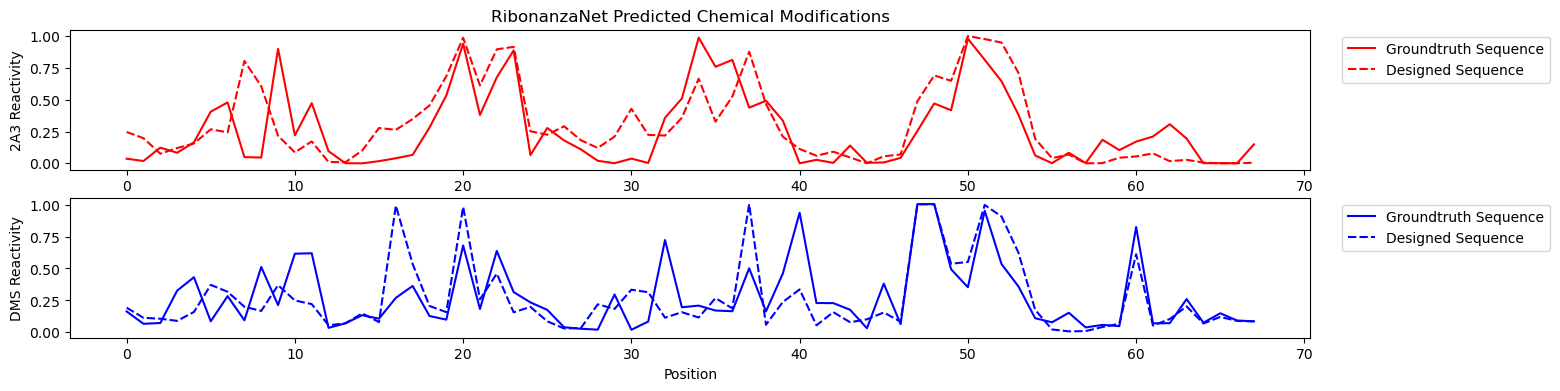

______________________________________________________________________________________________________________________________________________________
>sample=2, gRNAde_ARv1_1state_all.h5 seed=0 temperature=0.5 perplexity=1.3129 recovery=0.6618 edit_dist=23 sc_score=0.5339 sc_score_ribonanzanet=0.1679 sc_score_rmsd=8.0584 sc_score_tm=0.2643 sc_score_gdt=0.2757
GGCCGCAACCAACCGUCAUGAUAUGGUUGGCGGGUAUCUACCAGAAGCCUUAAACUUCUG
AUGUUGCG

Sample 2
    Designed sequence:    GGCCGCAACCAACCGUCAUGAUAUGGUUGGCGGGUAUCUACCAGAAGCCUUAAACUUCUGAUGUUGCG
    Groundtruth sequence: GGGAAGAUAUAAUCCUAAUGAUAUGGUUUGGGAGUUUCUACCAAGAGCCUUAAACUCUUGAUUAUCUU
    Perplexity: 1.3129
    Recovery: 0.6618
    Edit distance: 23

    Predicted secondary structure:   ...(((((((((((((......))))))))...........((((((.......))))))...)))))
    Groundtruth secondary structure: ...((((((.(.(((((((.......)))))))((....))((((((.......)))))).)))))))
    SC Score (MCC using EternaFold): 0.5339
    SC Score (MAE using RibonanzaNet): 0.167

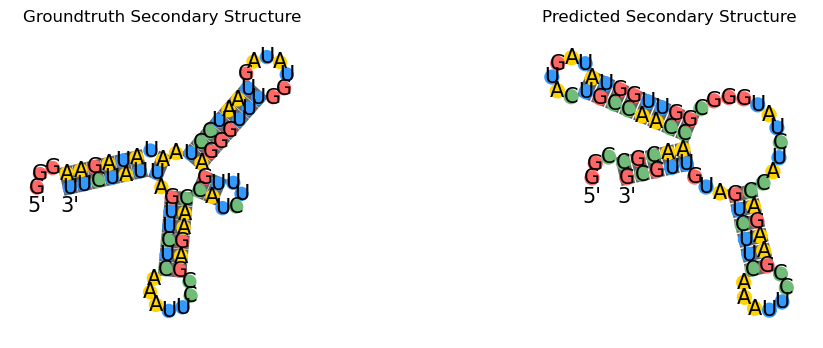

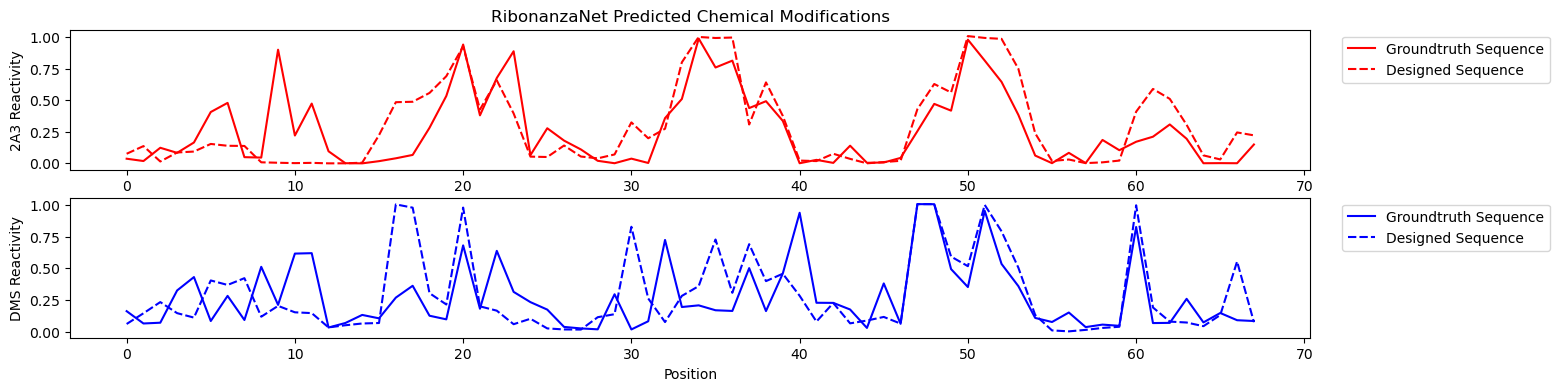

______________________________________________________________________________________________________________________________________________________
>sample=3, gRNAde_ARv1_1state_all.h5 seed=0 temperature=0.5 perplexity=1.3221 recovery=0.7353 edit_dist=18 sc_score=0.8794 sc_score_ribonanzanet=0.1451 sc_score_rmsd=3.6842 sc_score_tm=0.4925 sc_score_gdt=0.4853
GGCGGGGCACAACCCUCAUGAUAUGGUUGGGGGGUAUAUACCGAGAGCCUUAAACUCUCG
AUUGCCCC

Sample 3
    Designed sequence:    GGCGGGGCACAACCCUCAUGAUAUGGUUGGGGGGUAUAUACCGAGAGCCUUAAACUCUCGAUUGCCCC
    Groundtruth sequence: GGGAAGAUAUAAUCCUAAUGAUAUGGUUUGGGAGUUUCUACCAAGAGCCUUAAACUCUUGAUUAUCUU
    Perplexity: 1.3221
    Recovery: 0.7353
    Edit distance: 18

    Predicted secondary structure:   ...((((((..(((((((.........)))))).)......((((((.......))))))..))))))
    Groundtruth secondary structure: ...((((((.(.(((((((.......)))))))((....))((((((.......)))))).)))))))
    SC Score (MCC using EternaFold): 0.8794
    SC Score (MAE using RibonanzaNet): 0.145

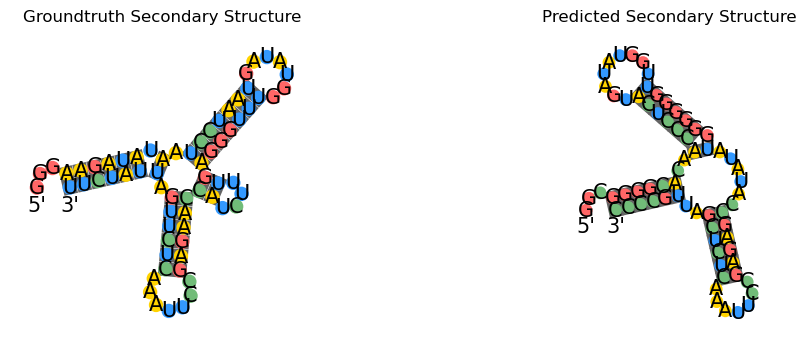

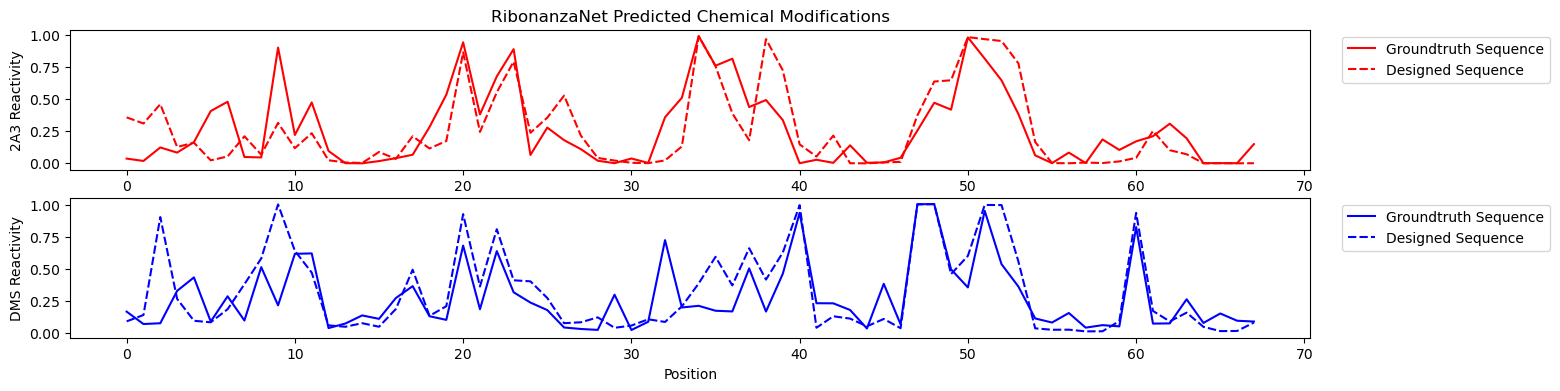

______________________________________________________________________________________________________________________________________________________



In [11]:
####################################
# Visualise and select best designs
####################################

# collate designed sequences in fasta format
# first record: input sequence and model metadata
input_seq = SeqRecord(
        Seq(raw_data["sequence"]),
        id=f"input_sequence,",
        description=f"checkpoint={os.path.split(model_path)[-1]}, seed={seed}"
    )
sequences = [input_seq]
# remaining records: designed sequences and metrics
for idx, zipped in enumerate(zip(
    samples.cpu().numpy(),
    perplexity,
    recovery,
    sc_score,
    pred_sec_structs,
    sc_score_ribonanza,
    pred_chem_mods,
    sc_score_rmsd,
    sc_score_tm,
    sc_score_gdt
)):
    seq, perp, rec, sc, pred_ss, sc_ribo, pred_cm, sc_rmsd, sc_tm, sc_gdt = zipped
    seq = "".join([NUM_TO_LETTER[num] for num in seq])
    edit_dist = edit_distance(seq, raw_data['sequence'])
    sequences.append(SeqRecord(
        Seq(seq), id=f"sample={idx},",
        description=f"{os.path.split(model_path)[-1]} seed={seed} temperature={temperature} perplexity={perp:.4f} recovery={rec:.4f} edit_dist={edit_dist} sc_score={sc:.4f} sc_score_ribonanzanet={sc_ribo:.4f} sc_score_rmsd={sc_rmsd:.4f} sc_score_tm={sc_tm:.4f} sc_score_gdt={sc_gdt:.4f}"
    ))
    
    print(sequences[-1].format('fasta'))
    print(f"Sample {idx}")
    print(f"    Designed sequence:    {seq}")
    print(f"    Groundtruth sequence: {raw_data['sequence']}")
    print(f"    Perplexity: {perp:.4f}")
    print(f"    Recovery: {rec:.4f}")
    print(f"    Edit distance: {edit_dist}")
    print()
    print(f"    Predicted secondary structure:   {pred_ss[0]}")
    print(f"    Groundtruth secondary structure: {raw_data['sec_struct_list'][0]}")
    print(f"    SC Score (MCC using EternaFold): {sc:.4f}")
    print(f"    SC Score (MAE using RibonanzaNet): {sc_ribo:.4f}")
    print(f"    SC Score (RMSD using RhoFold): {sc_rmsd:.4f}")
    print(f"    SC Score (TM using RhoFold): {sc_tm:.4f}")
    print(f"    SC Score (GDT using RhoFold): {sc_gdt:.4f}")
    
    # create two subplots for predicted and groundtruth secondary structure
    plt.figure(figsize=(12, 4))
    ax1 = plt.subplot(1, 2, 1)
    plt.title('Groundtruth Secondary Structure')
    draw_2d_struct(raw_data['sequence'], raw_data['sec_struct_list'][0], ax=ax1)
    ax2 = plt.subplot(1, 2, 2)
    plt.title('Predicted Secondary Structure')
    draw_2d_struct(seq, pred_ss[0], ax=ax2)
    plt.show()

    # plot predicted and groundtruth chemical modification
    plt.figure(figsize=(16, 4))
    ax1 = plt.subplot(2, 1, 1)
    plt.title('RibonanzaNet Predicted Chemical Modifications')
    df = pd.DataFrame({
        "Position": np.concatenate([np.arange(len(raw_data['sequence']))]*4),
        "Reactivity": np.concatenate([
            raw_data["ribonanzanet_chem_mod"][:,0].cpu().numpy(), 
            raw_data["ribonanzanet_chem_mod"][:,1].cpu().numpy(), 
            pred_cm[:,0].cpu().numpy(),
            pred_cm[:,1].cpu().numpy(),
        ]),
        "Source": np.concatenate([
            ["Groundtruth Sequence"]*len(raw_data["ribonanzanet_chem_mod"])*2, 
            ["Designed Sequence"]*len(pred_cm)*2,
        ]),
        "Type": np.concatenate([
            ["2A3"]*len(raw_data["ribonanzanet_chem_mod"]),
            ["DMS"]*len(raw_data["ribonanzanet_chem_mod"]), 
            ["2A3"]*len(pred_cm),
            ["DMS"]*len(pred_cm),
        ])
    })
    sns.lineplot(data=df.loc[df.Type == "2A3"], x="Position", y="Reactivity", style="Source", ax=ax1, color="red")
    ax1.set_ylabel("2A3 Reactivity")
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    ax2 = plt.subplot(2, 1, 2)
    sns.lineplot(data=df.loc[df.Type == "DMS"], x="Position", y="Reactivity", style="Source", ax=ax2, color="blue")
    ax2.set_ylabel("DMS Reactivity")
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.show()
    print("_"*150)

# write all designed sequences to output filepath
SeqIO.write(sequences, os.path.join(output_dir, "all_designs.fasta"), "fasta")
print()

In [ ]:
# # remove output directory
# import shutil
# shutil.rmtree(output_dir)